In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import thư viện

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Config một số tham số

In [ ]:
batch_size = 32
input_size = 160
model_name = "mobilenet_V2"
version =  1
initial_epochs = 50
base_learning_rate = 0.0001

In [ ]:
path_colab_drive =  '/content/drive/MyDrive/20.05.2023/classification/'

In [ ]:
!cp -R "{path_colab_drive}/data" /content/data
!unzip /content/data/data_end.zip
!rm /content/data/data_end.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/Training/meningioma/m1(56).jpg  
  inflating: data/Training/meningioma/m1(57).jpg  
  inflating: data/Training/meningioma/m1(58).jpg  
  inflating: data/Training/meningioma/m1(59).jpg  
  inflating: data/Training/meningioma/m1(6).jpg  
  inflating: data/Training/meningioma/m1(60).jpg  
  inflating: data/Training/meningioma/m1(61).jpg  
  inflating: data/Training/meningioma/m1(62).jpg  
  inflating: data/Training/meningioma/m1(63).jpg  
  inflating: data/Training/meningioma/m1(64).jpg  
  inflating: data/Training/meningioma/m1(65).jpg  
  inflating: data/Training/meningioma/m1(66).jpg  
  inflating: data/Training/meningioma/m1(67).jpg  
  inflating: data/Training/meningioma/m1(68).jpg  
  inflating: data/Training/meningioma/m1(69).jpg  
  inflating: data/Training/meningioma/m1(7).jpg  
  inflating: data/Training/meningioma/m1(70).jpg  
  inflating: data/Training/meningioma/m1(71).jpg  
  inflating: data/Training/mening

# Xóa ảnh lỗi

In [ ]:
import os
from PIL import Image
import cv2

count = 0
list_foler = ["/content/data/Training/", "/content/data/Testing/"]
for folder in list_foler:
    for class_folder in os.listdir(folder):
        folder_path = os.path.join(folder, class_folder)
        flag_break = False
        for img_file in os.listdir(folder_path):
            old_img_file_path = os.path.join(folder_path, img_file)
            filename, ext = os.path.splitext(img_file)
            new_img_file_path = os.path.join(folder_path, filename + '.jpg')
            try:
                new_img = Image.open(old_img_file_path)
                new_img.save(new_img_file_path, format="JPEG", quality=100)
                if old_img_file_path != new_img_file_path:
                    new_img.close()
                    os.remove(old_img_file_path)
            except Exception as e:
                new_img.close()
                os.remove(old_img_file_path)
                print("Remove: ",old_img_file_path)
                count += 1
                continue
print("Number of data remove is: ", count)

Remove:  /content/data/Training/notumor/Tr-no_1019.jpg
Remove:  /content/data/Training/notumor/Tr-no_1011.jpg
Remove:  /content/data/Training/notumor/Tr-no_1012.jpg
Remove:  /content/data/Training/notumor/Tr-no_1020.jpg
Number of data remove is:  4


## Xử lý ảnh: đưa ảnh về đúng kích thước (160, 160)

In [ ]:
train_dir = '/content/data/Training'
validation_dir = test_dir = '/content/data/Testing'
BATCH_SIZE = batch_size
IMG_SIZE = (input_size, input_size)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)
test_dataset = image_dataset_from_directory(test_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)
class_names = test_dataset.class_names

Found 6996 files belonging to 4 classes.
Found 1400 files belonging to 4 classes.
Found 1400 files belonging to 4 classes.


### Bộ dữ liệu phân loại các loại u nao

*   List item
*   List item



In [ ]:
class_names = train_dataset.class_names
print("Các class: ", class_names)
num_classes = len(class_names)
print("Số lượng class: ", num_classes)

Các class:  ['glioma', 'meningioma', 'notumor', 'pituitary']
Số lượng class:  4


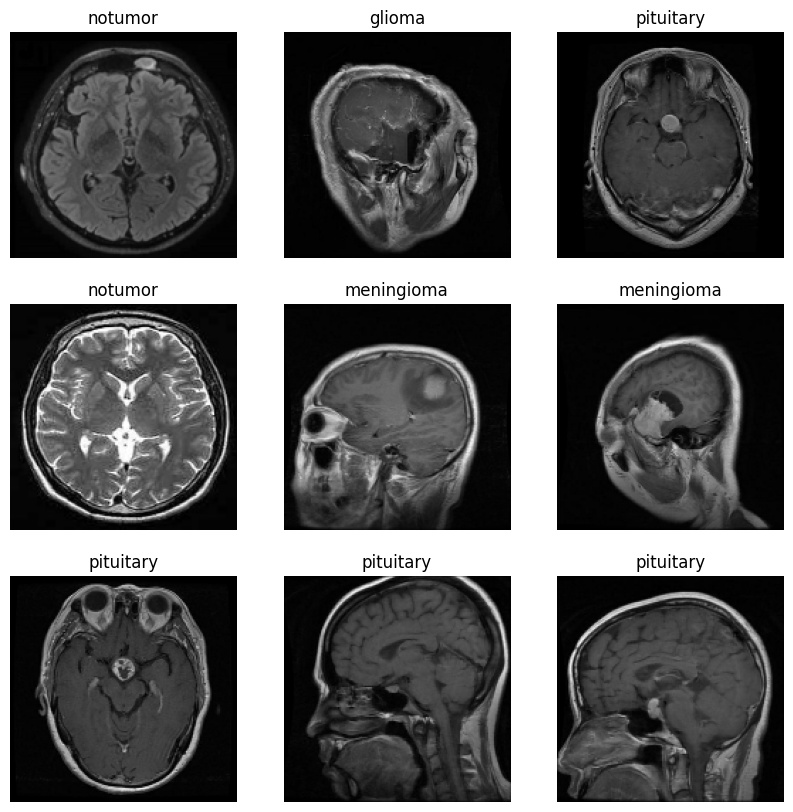

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    try:
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    except:
        continue

### Tiếp tục xử lý ảnh như: xoay, làm nhiễu,...

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomContrast(1),
  tf.keras.layers.experimental.preprocessing.RandomRotation((-1, 0.5)),
  tf.keras.layers.experimental.preprocessing.RandomCrop(160,160),
  tf.keras.layers.GaussianNoise(0.2)
])

## Xây dựng mô hình

### Pretrained

In [ ]:
preprocess_input = tf.keras.applications.mobilenet.preprocess_input
model_type = tf.keras.applications.MobileNetV2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = model_type(input_shape=IMG_SHAPE,
                        include_top=False,
                        weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
try:
    image_batch, label_batch  = iter(train_dataset)
except:
    image_batch, label_batch  = next(iter(train_dataset))

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

## Kiến trúc cơ sở

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

**Tính toán giá trị trung bình toàn cục của các đặc trưng đầu vào và gán kết quả vào biến feature_batch_average.**

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(num_classes, name='predict')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


### Mô hình

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE, name='image_tensor')
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs, name=model_name)

In [ ]:
checkpoints_path = "/content/drive/MyDrive/checkpoint/"
if not os.path.exists(checkpoints_path):
    os.makedirs(checkpoints_path)

## Huấn luyện

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()
print(f"Number of trainable variables: {len(model.trainable_variables)}")

Model: "mobilenet_V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_tensor (InputLayer)   [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                      

In [ ]:
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

44/44 [==============================] - 6s 55ms/step - loss: 1.5715 - accuracy: 0.2914
initial loss: 1.57
initial accuracy: 0.29


In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoints_path, 'model_checkpoint.h5'),
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch'
)
callbacks = [checkpoint_callback]

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/50
219/219 [==============================] - ETA: 0s - loss: 0.7555 - accuracy: 0.6958
Epoch 1: val_accuracy improved from -inf to 0.78714, saving model to /content/drive/MyDrive/checkpoint/model_checkpoint.h5
219/219 [==============================] - 25s 93ms/step - loss: 0.7555 - accuracy: 0.6958 - val_loss: 0.5636 - val_accuracy: 0.7871
Epoch 2/50
218/219 [============================>.] - ETA: 0s - loss: 0.5242 - accuracy: 0.7970
Epoch 2: val_accuracy did not improve from 0.78714
219/219 [==============================] - 17s 74ms/step - loss: 0.5241 - accuracy: 0.7970 - val_loss: 0.6140 - val_accuracy: 0.7607
Epoch 3/50
218/219 [============================>.] - ETA: 0s - loss: 0.4661 - accuracy: 0.8205
Epoch 3: val_accuracy improved from 0.78714 to 0.79643, saving model to /content/drive/MyDrive/checkpoint/model_checkpoint.h5
219/219 [==============================] - 19s 85ms/step - loss: 0.4661 - accuracy: 0.8206 - val_loss: 0.5252 - val_accuracy: 0.7964
Epoch 4/50
21

In [ ]:
accurary = max(history.history['val_accuracy'])
print("Đô chính xác: ", accurary)

Đô chính xác:  0.8592857122421265


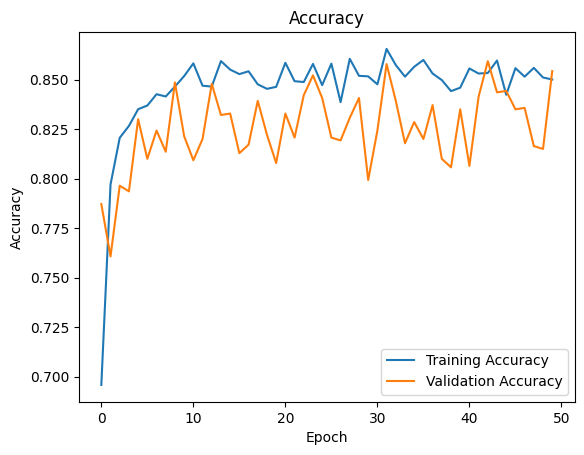

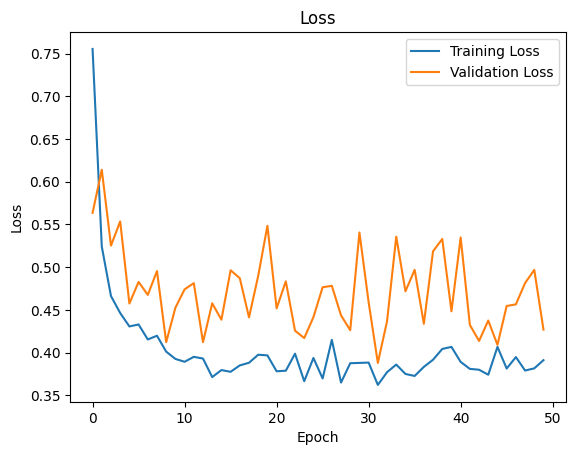

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Vẽ biểu đồ độ chính xác
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Vẽ biểu đồ mất mát
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


### Lưu mô hình

In [ ]:
model.save(f'{path_colab_drive}/model/model.h5', include_optimizer=True)

# Đánh giá

In [4]:
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
import os
import cv2
import tensorflow as tf
import numpy as np

In [5]:
def evulate(data_end):
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

    # load model
    model = load_model('/content/drive/MyDrive/20.05.2023/classification/model/model.h5')

    result = []
    for img_path in data_end:
      img_arr = cv2.imread(img_path)
      np_img = np.array(img_arr)

      # print(np_img.shape)
      image = np.expand_dims(cv2.resize(np.squeeze(np_img), (160, 160)), axis=0)

      predictions = model.predict(image)
      scores = tf.nn.sigmoid(predictions) # 4 > 100%
      pred_labels = np.argmax(scores, axis=-1)
      result.append(int(pred_labels))
    return result

In [6]:

data_dir = '/content/drive/MyDrive/20.05.2023/classification/data/data_end/Testing'  # Đường dẫn tới thư mục chứa dữ liệu
class_names = os.listdir('/content/drive/MyDrive/20.05.2023/classification/data/data_end/Testing')  # Lấy danh sách tên các lớp từ tên thư mục
image_size = (64, 64)  # Kích thước ảnh đầu vào
test_size = 0.2  # Tỉ lệ dữ liệu dùng để kiểm tra

data_end = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        data_end.append(image_path)
        labels.append(class_name)

In [7]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [8]:
y_true = [class_names.index(x) for x in labels]

In [9]:
y_predict = evulate(data_end)

1/1 [==============================] - 0s 27ms/step


              precision    recall  f1-score   support

      glioma       0.85      0.88      0.86       350
  meningioma       0.82      0.65      0.72       350
     notumor       0.95      0.92      0.93       350
   pituitary       0.80      0.96      0.87       350

    accuracy                           0.85      1400
   macro avg       0.85      0.85      0.85      1400
weighted avg       0.85      0.85      0.85      1400


Confusion matrix: X-Dự Đoán 	 Y-Nhãn Thật
0-Glioma	1-Meningioma		2-Noturmor	 3-Pitutary


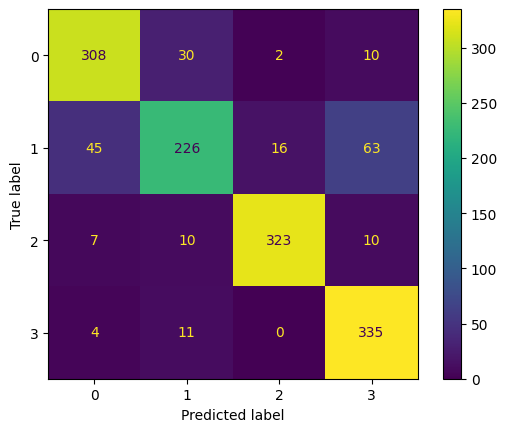

In [10]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

target_names = ['glioma', 'meningioma', 'notumor','pituitary']

print(classification_report(y_true, y_predict, target_names=target_names))

ConfusionMatrixDisplay.from_predictions(
    y_true, y_predict
)
print("\nConfusion matrix: X-Dự Đoán \t Y-Nhãn Thật\n0-Glioma\t1-Meningioma\t\t2-Noturmor\t 3-Pitutary")

# Dự đoán

In [43]:
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
model_path = ('/content/drive/MyDrive/20.05.2023/classification/model/model.h5')
target_names = ['glioma', 'meningioma', 'notumor','pituitary']


def predict_class_img_with_img(img_path):
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    # load model
    model = load_model(model_path)
    img_arr = cv2.imread(img_path)
    image = cv2.resize(img_arr, dsize=(160,160))

    # print(np_img.shape)
    image = np.expand_dims(image, axis=0)

    predictions = model.predict(image)
    print(predictions)
    best = np.argmax(predictions[0], axis=0)
    score = predictions[0][best]
    print(score)

    print(f"Label is {class_names[int(best)]}, score is {score * 100}%")
    cv2_imshow(image[0])
    # return class_names[int(pred_labels)]

1/1 [==============================] - 1s 873ms/step
[[ 4.7687845  1.0560266 -9.694273  -1.8772863]]
4.7687845
Label is glioma, score is 476.8784523010254%


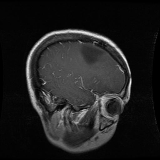

In [46]:
img_path = '/content/drive/MyDrive/20.05.2023/classification/data/data_end/Testing/glioma/Te-gl_0196.jpg'
predict_class_img_with_img(img_path)

In [52]:
model = load_model(model_path)

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
model_path = ('/content/drive/MyDrive/20.05.2023/classification/model/model.h5')
target_names = ['glioma', 'meningioma', 'notumor','pituitary']


def predict_class_img_with_img(img_path):
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    # load model
    model = load_model(model_path)
    img_arr = cv2.imread(img_path)
    image = cv2.resize(img_arr, dsize=(160,160))

    # print(np_img.shape)
    image = np.expand_dims(image, axis=0)

    predictions = model.predict(image)
    print(predictions)
    best = np.argmax(predictions[0], axis=0)
    score = predictions[0][best]
    print(score)

    print(f"Label is {class_names[int(best)]}, score is {score * 100}%")
    cv2_imshow(image[0])
    # return class_names[int(pred_labels)]

1/1 [==============================] - 1s 883ms/step
[[ 2.2495222 -3.4654036 -7.9934936 -2.829091 ]]
2.2495222
Label is glioma, score is 224.95222091674805%


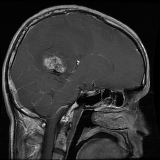

In [55]:

img_path = '/content/drive/MyDrive/20.05.2023/classification/data/data_end/Testing/glioma/Te-gl_0221.jpg'
predict_class_img_with_img(img_path)

In [ ]:
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import cv2

model_path = f'{path_colab_drive}/model/model.h5'

def predict_class_img_with_img(img_path):
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

    # load model
    model = load_model(model_path)
    img_arr = cv2.imread(img_path)
    np_img = np.array(img_arr)

    # print(np_img.shape)
    image = np.expand_dims(cv2.resize(np.squeeze(np_img), (160, 160)), axis=0)

    predictions = model.predict(image)
    scores = tf.nn.sigmoid(predictions)
    print(scores)
    pred_labels = np.argmax(scores, axis=-1)
    print(f"Label is {class_names[int(pred_labels)]}, score is {np.max(scores) * 100}%")
    cv2_imshow(image[0])
    # return class_names[int(pred_labels)]

1/1 [==============================] - 1s 1s/step
tf.Tensor([[9.5012283e-01 2.4015416e-01 3.8999182e-04 2.8824669e-01]], shape=(1, 4), dtype=float32)
Predicted labels: ['glioma']


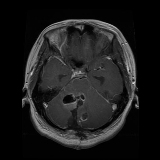

In [ ]:

img_path = '/content/drive/MyDrive/20.05.2023/classification/data/data_end/Testing/glioma/Te-gl_0020.jpg'
predict_class_img_with_img(img_path)

1/1 [==============================] - 1s 941ms/step
tf.Tensor([[0.18483852 0.2177979  0.10893562 0.237308  ]], shape=(1, 4), dtype=float32)
Label is pituitary, score is 23.730799555778503%


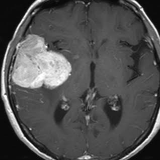

In [ ]:

img_path = '/content/drive/MyDrive/20.05.2023/classification/data/data_end/Testing/meningioma/Te-me_0025.jpg'
predict_class_img_with_img(img_path)

1/1 [==============================] - 1s 930ms/step
tf.Tensor([[4.8547906e-01 1.6512248e-01 9.9969792e-01 4.9788000e-06]], shape=(1, 4), dtype=float32)
Label is notumor, score is 99.96979236602783%


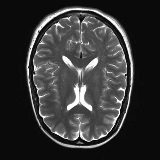

In [ ]:
img_path = '/content/drive/MyDrive/20.05.2023/classification/data/data_end/Training/notumor/Tr-no_0597.jpg'
predict_class_img_with_img(img_path)

In [ ]:
img_path = '/content/drive/MyDrive/20.05.2023/classification/data/data_end/Testing/pituitary/Te-pi_0157.jpg'
predict_class_img_with_img(img_path)